<img src="https://i1.wp.com/www.biologia.uson.mx/wp-content/uploads/2017/09/logo-transparente.png" width="150px" height="150px">

**Universidad de Sonora**

**Reconocimiento de Patrones**

**Integrantes: Francisco Yanez y Luis Hiram**

**Proyecto Final: Estrés Hídrico en Sonora**

# Problemática

    En Sonora hay un problema real sobre la disponibilidad de recursos hídricos para el consumo humano, la industria, la agricultura y la ganadería. Para que el gobierno pueda evaluar e implementar políticas públicas adecuadas, es necesario poder predecir con márgenes de error bien establecidos, cuales van a ser los recursos hídricos que se dispongan en un futuro.

# Introducción

    Nuestra intención con este proyecto es generar un predicción sobre la disponibilidad de agua en diferentes presas alrededor de Sonora. Usaremos un modelo de... . Esto lo haremos utilizando diferentes conjuntos de datos, tales como los recursos hídricos en presas proporcionados por la gobernación de Sonora, además de buscar en diferentes sitios meteorológicos tanto nacionales como internacionales.

# Codigo Pyhton

In [1]:
# Importamos librerias necesarias

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tablafinal/tabla_final.csv
/kaggle/input/datosfinal/tabla_final.csv
/kaggle/input/datosproyecto/almacenamiento.csv
/kaggle/input/datosproyecto/climahmo.csv
/kaggle/input/datosproyecto/almac_reciente.csv
/kaggle/input/datosproyecto/nombres_presas.csv


# Leemos los datos

In [2]:
# Cargamos los datos con los que trabajaremos en este proyecto
df = pd.read_csv('/kaggle/input/tablafinal/tabla_final.csv', parse_dates =['fecha'])
info_presas = pd.read_csv('/kaggle/input/datosproyecto/nombres_presas.csv')
storage = pd.read_csv('/kaggle/input/datosproyecto/almacenamiento.csv', parse_dates =['fecha'])

# Informacion adicional importante de los datos
    Se muestran a continuacion los diferentes represos con los que se trabajaron en este proyecto, asi como informacion sobre ellos: Nombre oficial, Apodo, Ubicacion, Latitud, Longitud, etc..

In [3]:
info_presas.head(10)

,Clave,Presa,Nombre_comun,Estado,Municipio,Rio,Numero,Latitud,Longitud,Altitud
0,LCDSO,Lazaro Cardenas,La Angostura,Sonora,Nacozari de Garcia,Rio Yaqui,30,-109,860,102
1,PECSO,Plutarco Elias Calles,El Novillo,Sonora,Soyopa,Rio Yaqui,29,-110,2110,103
2,AOBSO,Alvaro Obregon,Oviachic,Sonora,Cajeme,Rio Yaqui,28,-110,116,104
3,AGZCH,Abraham Gonzalez,Guadalupe,Chihuahua,Guerrero,Otros,28,-107,2020,103
4,ARCSO,Adolfo Ruiz Cortines,Mocuzari,Sonora,Alamos,Rio Mayo,27,-109,148,108
5,PMOSO,Ing. Rodolfo Felix Valdes,El Molinito,Sonora,Hermosillo,Rio Sonora,29,-111,321,100
6,ARLSO,Abelardo Rodriguez Lujan,Hermosillo,Sonora,Hermosillo,Rio Sonora,29,-111,230,100
7,CHTSO,Cuauhtemoc,Santa Teresa,Sonora,Tubutama,Otros,31,-112,590,92
8,IRASO,Ignacio R. Alatorre,Punta de Agua,Sonora,Guaymas,Otros,28,-110,245,110
9,BICSO,Bicentenario,Los Pilares,Sonora,Alamos,Rio Mayo,27,-109,164,108


Con la ayuda del **Gobierno de Sonora**, hemos podido obtener una base de datos que contiene la informacion respecto al **nivel de agua que hay en diferentes represos en Sonora**. A continuacion, mostramos como ha cambiado el nivel del agua con lo años. En total tenemos **10 represos distintos**, cada uno con una clave que los identifica. Para un mejor entendimiento **se dividío la tabla en 2 grupos**.

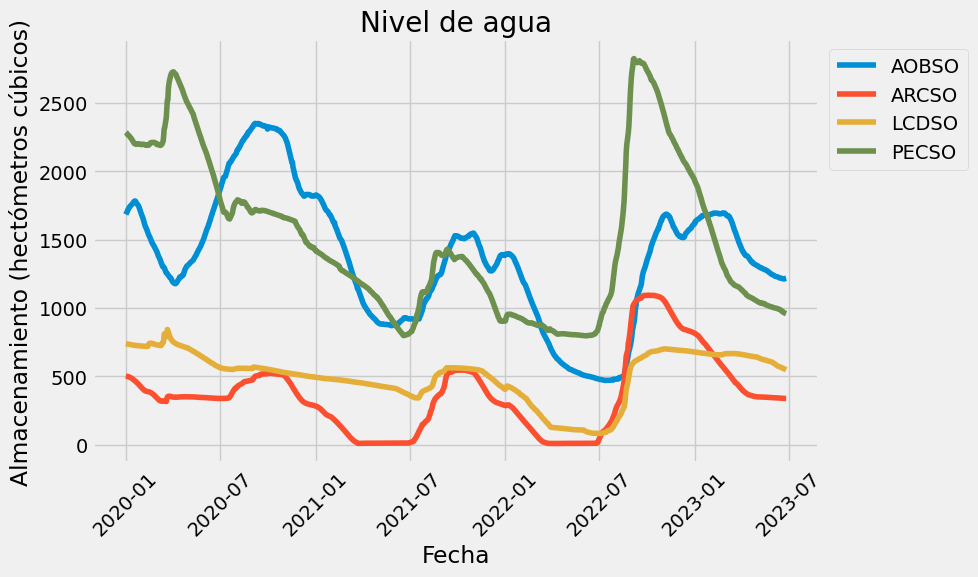

In [4]:
# Represos que graficaremos
claves = ["PECSO", "AOBSO", "ARCSO", "LCDSO"]
data_filtrada = storage[storage['clave'].isin(claves)]

# Creamos la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Iteraramos sobre los diferentes represos
for clave, grupo in data_filtrada.groupby("clave"):
    # Graficamos el nivel de agua para cada represo
    ax.plot(grupo["fecha"], grupo["almacenamiento"], label=clave)

# Personalizamos el gráfico
ax.set_title("Nivel de agua")
ax.set_xlabel("Fecha")
ax.set_ylabel("Almacenamiento (hectómetros cúbicos)")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Rotamos las fechas en el eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostramos el gráfico
plt.tight_layout()
plt.show()

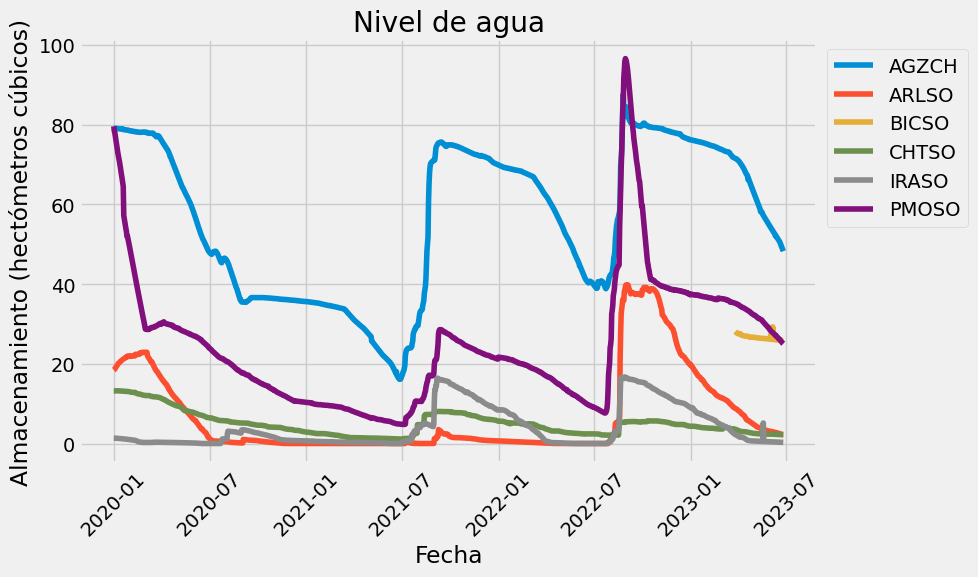

In [5]:
# Represos que graficaremos
claves = ["AGZCH", "ARLSO", "CHTSO", "IRASO", "PMOSO", "BICSO"]
data_filtrada = storage[storage['clave'].isin(claves)]

# Creamos la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Iteramos sobre los distintos represos
for clave, grupo in data_filtrada.groupby("clave"):
    # Graficamos el nivel de agua para cada represo
    ax.plot(grupo["fecha"], grupo["almacenamiento"], label=clave)

# Personalizamos el gráfico
ax.set_title("Nivel de agua")
ax.set_xlabel("Fecha")
ax.set_ylabel("Almacenamiento (hectómetros cúbicos)")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Rotamos las fechas en el eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Conocemos nuestro dataset

In [6]:
# Cambiamos el formato y actualizamos el indice
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y/%m/%d')
df = df.set_index('fecha')
# En este caso trabajaremos con el represo AGZCH 
df = df[df['clave'] == 'AGZCH']
df = df.drop('clave', axis = 1)
# Mostramos los datos de este represo
df

,almacenamiento,temp,humidity,precip,preciptype,uvindex,conditions_Clear,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy"
fecha,,,,,,,,,,,,
2020-01-01,79.100,14.7,65.0,0.0,0,6,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,79.100,14.5,69.0,0.0,0,6,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,79.100,13.5,60.5,0.0,0,6,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,79.100,14.3,55.2,0.0,0,7,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,79.040,16.4,55.6,0.0,0,7,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-22,49.640,34.7,11.9,0.0,0,10,0.0,0.0,1.0,0.0,0.0,0.0
2023-06-23,49.285,34.6,10.0,0.0,0,10,1.0,0.0,0.0,0.0,0.0,0.0
2023-06-24,48.931,35.4,6.6,0.0,0,9,1.0,0.0,0.0,0.0,0.0,0.0


# Graficamos los datos historicos de la presa (2020 - 2023)

<Axes: xlabel='fecha'>

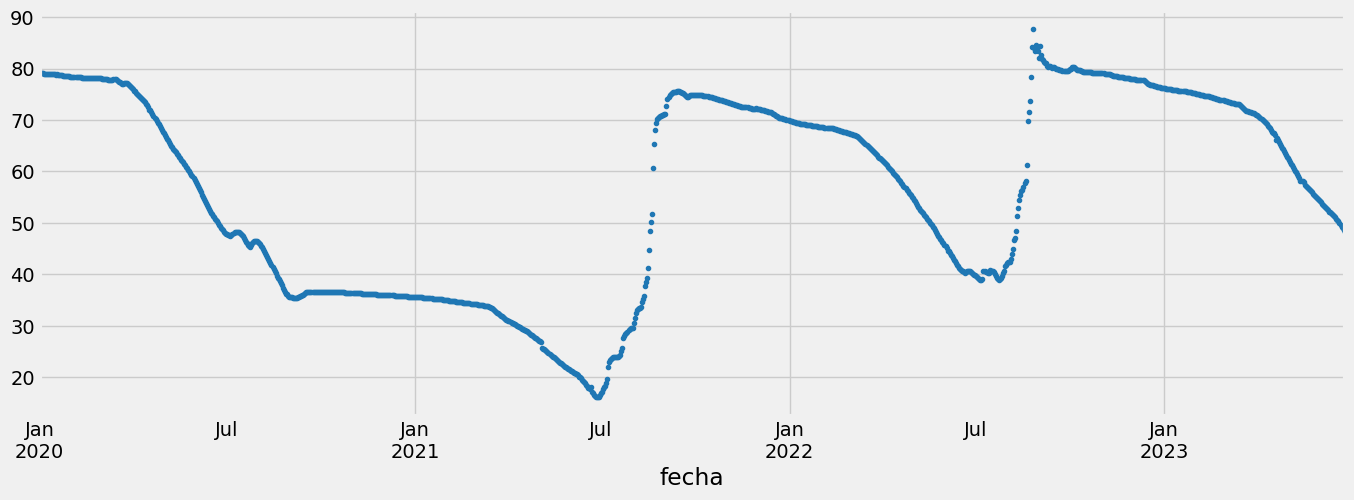

In [7]:
df['almacenamiento'].plot(style='.', figsize=(15,5),color = color_pal[0])

# Creacion de caracteristicas

In [8]:
# A partir de la informacion que tenemos en nuestro dataset, creamos caracteristicas que nos ayudaran con
# el modelado. 
def crear_caracteristicas(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df


In [9]:
def add_lags(df):
    target_map = df['almacenamiento'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

# Funcion principal

In [10]:
def prediccion(df):
    # dividimos nuestro data set a partir del 1ro de Julio
    train = df['almacenamiento'].loc[df.index < '2022-07-1']
    test = df['almacenamiento'].loc[df.index >= '2022-07-1']
    
    #Creamos la figura y los ejes
    fig,ax = plt.subplots(figsize = (15,5))
    train.plot(ax=ax, label= 'Training set')
    test.plot(ax=ax, label= 'Test set')
    ax.axvline('2022-07-1', color='black' , ls='--')
    ax.legend(['Training Set', 'Test Set'])
    plt.show()
    
    
    tss = TimeSeriesSplit(n_splits=3, test_size = 365, gap = 1)
    df = df.sort_index()
    
    fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

    fold = 0
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        train['almacenamiento'].plot(ax=axs[fold],
                              label='Training Set',
                              title=f'Data Train/Test Split Fold {fold}')
        test['almacenamiento'].plot(ax=axs[fold],
                             label='Test Set')
        axs[fold].axvline(test.index.min(), color='black', ls='--')
        fold += 1
    plt.show()
    
    # graficamos como se ven una semana de datos
    df['almacenamiento'].loc[(df['almacenamiento'].index > '2022-07-1') & (df['almacenamiento'].index > '2022-07-8')].plot(figsize = (15,5), title = 'Una Semana de datos')
    
    # Hacemos un boxplot que nos muestra los rangos en los que osciló el nivel de agua por año
    df = crear_caracteristicas(df)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.boxplot(data=df, x='year', y='almacenamiento')
    ax.set_title('Almacenamiento por año')
    plt.show()
    
    df = add_lags(df)
    
    
    #Hacemos cross validation para TimeSeries
    tss = TimeSeriesSplit(n_splits=3, test_size=365, gap=24)
    df = df.sort_index()


    fold = 0
    preds = []
    scores = []
    
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]

        train = crear_caracteristicas(train)
        test = crear_caracteristicas(test)

        FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                    'lag1','lag2','lag3', 'temp', 'humidity', 'precip', 'preciptype', 'uvindex',
       'conditions_Clear', 'conditions_Overcast',
       'conditions_Partially cloudy', 'conditions_Rain',
       'conditions_Rain, Overcast', 'conditions_Rain, Partially cloudy']
        TARGET = 'almacenamiento'

        X_train = train[FEATURES]
        y_train = train[TARGET]

        X_test = test[FEATURES]
        y_test = test[TARGET]

        #Creamos un modeelo de regresion de Xgboost
        reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                               n_estimators=1000,
                               early_stopping_rounds=50,
                               objective='reg:linear',
                               max_depth=3,
                               learning_rate=0.01)
        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)

        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)
        
        print(f'Score across folds {np.mean(scores):0.4f}')
        print(f'Fold scores:{scores}')
 
        #hacemos la prediccion:
        df = crear_caracteristicas(df)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
                'lag1','lag2','lag3', 'temp', 'humidity', 'precip', 'preciptype', 'uvindex',
       'conditions_Clear', 'conditions_Overcast',
       'conditions_Partially cloudy', 'conditions_Rain',
       'conditions_Rain, Overcast', 'conditions_Rain, Partially cloudy']
    TARGET = 'almacenamiento'

    # configuramos nuestro modelo
    X_all = df[FEATURES]
    y_all = df[TARGET]

    # configuramos los hiperparametros
    reg = xgb.XGBRegressor(base_score=0.5,
                           booster='gbtree',    
                           n_estimators=200,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    # Entrenamos el modelo
    reg.fit(X_all, y_all,
            eval_set=[(X_all, y_all)],
            verbose=100)
    
    #Creamos el dataframe de las predicciones para el 2024
    future = pd.date_range('2023-06-26', '2024-12-1')
    future_df = pd.DataFrame(index = future)
    future_df['isfuture'] = True
    df['isfuture'] = False
    df_and_future = pd.concat([df, future_df])
    df_and_future = crear_caracteristicas(df_and_future)
    df_and_future = add_lags(df_and_future)

    future_w_features = df_and_future.query('isfuture').copy()
    future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
    
    future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Predicciones 2024')
    plt.show()

# Resultados del Modelo

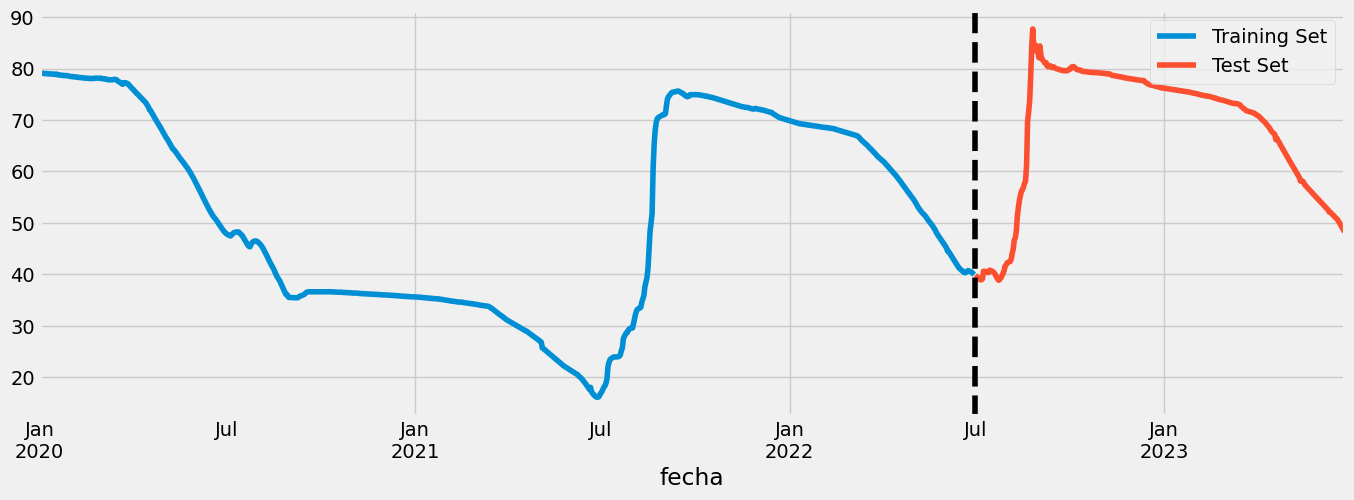

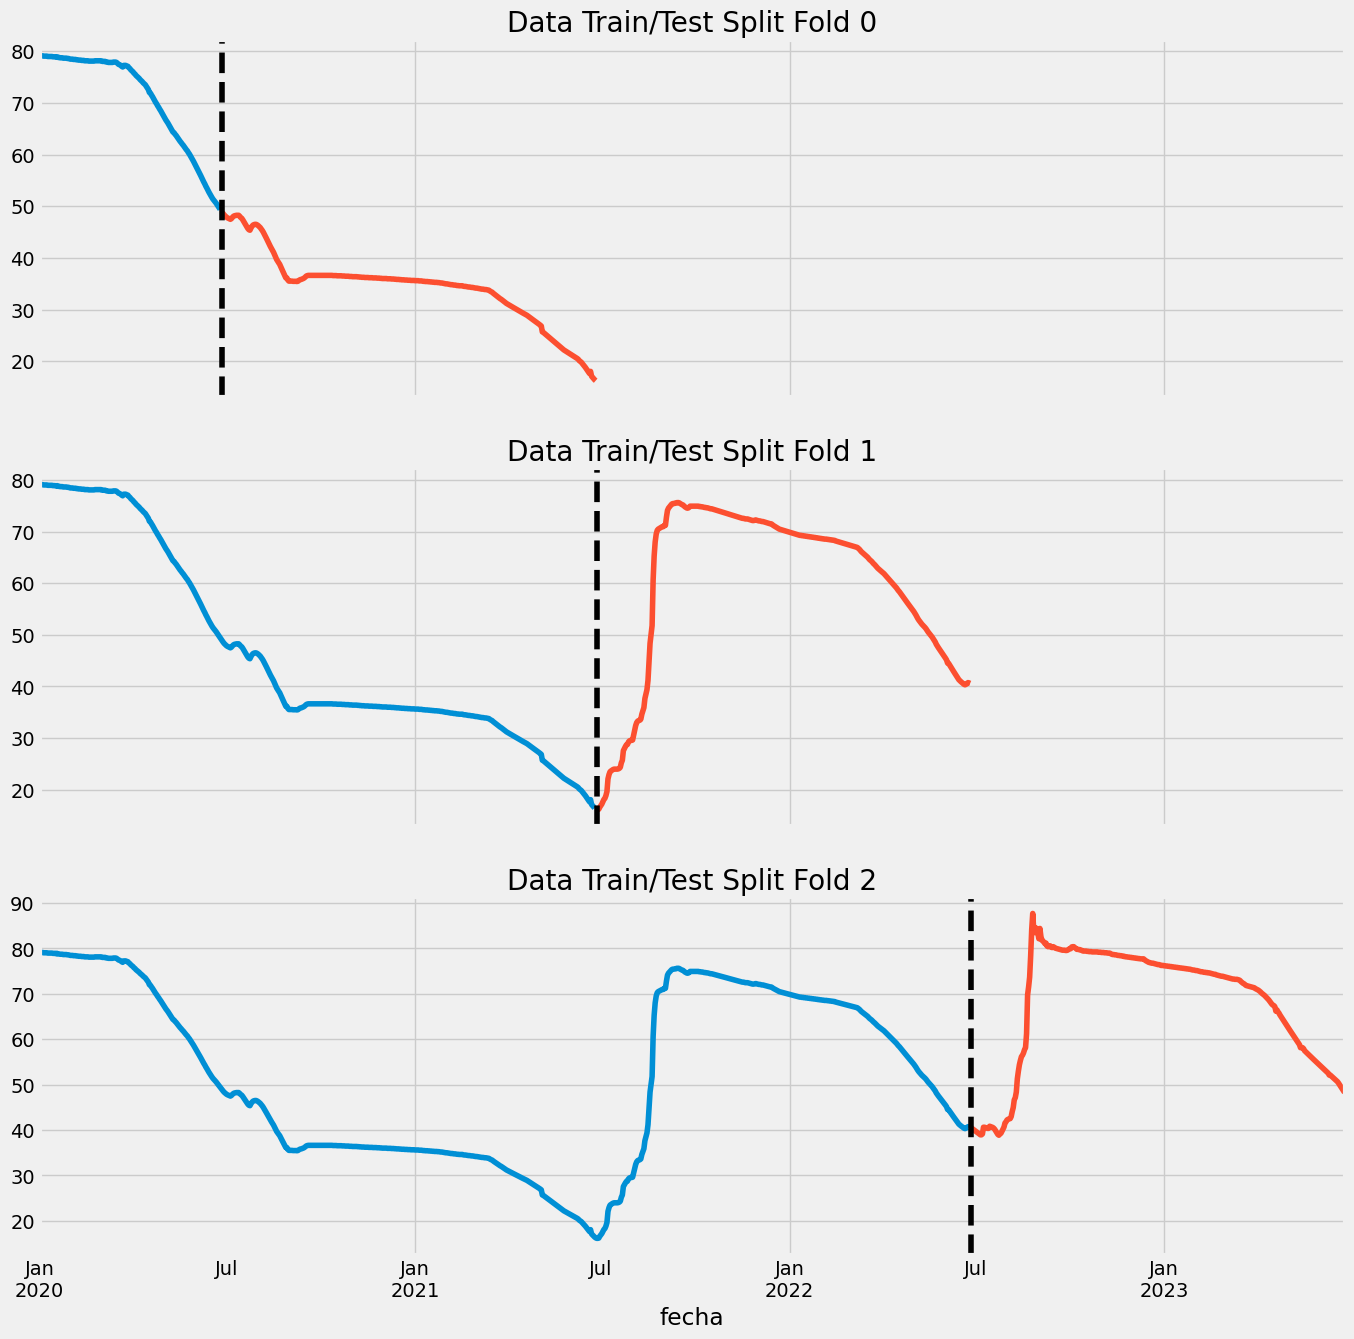

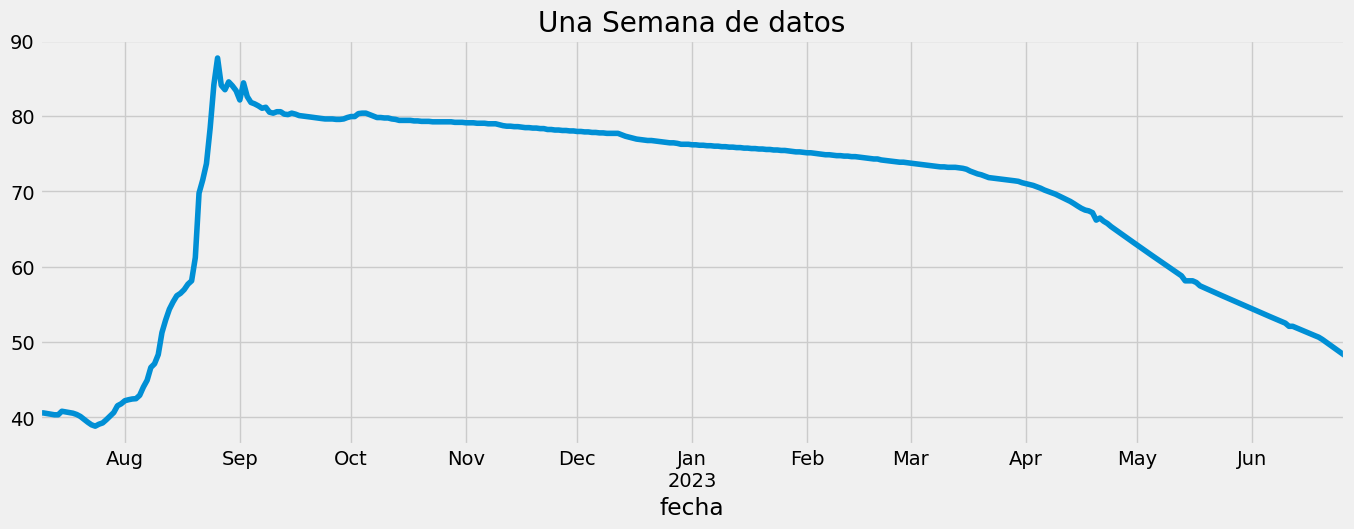

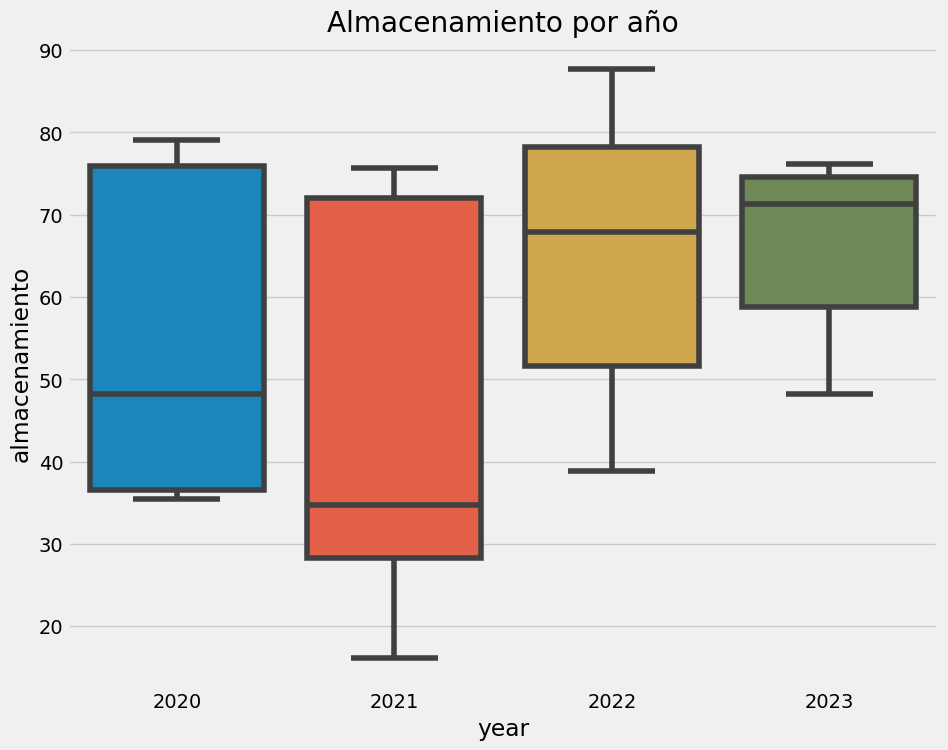

[0]	validation_0-rmse:72.75301	validation_1-rmse:33.97512
[100]	validation_0-rmse:27.01018	validation_1-rmse:12.01911
[119]	validation_0-rmse:22.38172	validation_1-rmse:15.34207
Score across folds 8.2207
Fold scores:[8.220723878067293]
[0]	validation_0-rmse:50.05483	validation_1-rmse:61.11053


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:26:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:26:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:18.59144	validation_1-rmse:47.26426
[200]	validation_0-rmse:6.91966	validation_1-rmse:42.59262
[300]	validation_0-rmse:2.59883	validation_1-rmse:40.94649
[400]	validation_0-rmse:1.00032	validation_1-rmse:40.32269
[500]	validation_0-rmse:0.41960	validation_1-rmse:40.00883
[600]	validation_0-rmse:0.22113	validation_1-rmse:39.90441
[700]	validation_0-rmse:0.16076	validation_1-rmse:39.88838
[742]	validation_0-rmse:0.15122	validation_1-rmse:39.89063
Score across folds 24.0536
Fold scores:[8.220723878067293, 39.88653802398874]
[0]	validation_0-rmse:54.38403	validation_1-rmse:68.43430
[100]	validation_0-rmse:20.41014	validation_1-rmse:50.72683


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:26:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:7.80211	validation_1-rmse:44.81913
[300]	validation_0-rmse:3.12720	validation_1-rmse:42.77218
[400]	validation_0-rmse:1.46793	validation_1-rmse:42.07091
[500]	validation_0-rmse:0.86712	validation_1-rmse:41.97100
[508]	validation_0-rmse:0.83942	validation_1-rmse:41.98335
Score across folds 30.0125
Fold scores:[8.220723878067293, 39.88653802398874, 41.93028956524007]
[0]	validation_0-rmse:58.43196
[100]	validation_0-rmse:23.18084
[199]	validation_0-rmse:11.06245


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:26:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


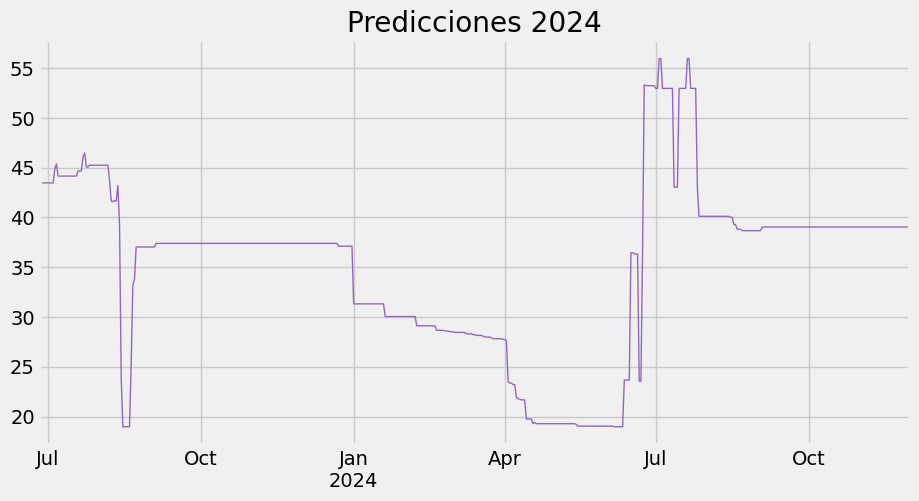

In [11]:
prediccion(df)

# Interpretacion del modelo

Aqui lo que observamos es muy interesante. El grafico nos muestra como en el año 2023 en los meses que van de julio a octubre, la presa muestra una disminucion extrema en los niveles de la presa. Esto se debe a que en ese año, las lluvias fueron muy escasas y por lo tanto no se acumuló agua de lluvia en la presa y se ocuparon mas recursos para satisfacer a la poblacion. 

Ademas podemos ver que de octubre en adelante, hasta finales de junio del año 2024, como no es temporada de lluvia, el nivel de agua de la presa se ve estancado, ademas de tener una gran disminucion por la entrada del calor y todos los efectos que este trae consigo. Como pueden ser el riego intensivo de los campos, uso de agua para el ganado, uso citadino etc. 

Lo que nos parece mas interesante es el increible aumento que se registra en los meses de julio y agosto. Lo que nos quiere decir este modelo es que predice que para el año de 2024, se esperan grandes lluvias, que traeran muchisma agua que beneficiará a todos. 